<center>
<h1 style="color:red; font-size:70px;"> Analisi dati AWS Col de Porte</h1>

L'obiettivo di questo notebook è quello di prendere confidenza con la libreria xarray, che contiene gli strumenti necessari per estrarre informazioni dai file NetCDF. In paricolare vorrei provare a valutare l'andamento dello spessore nivale a terra.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

<h1 style="color:blue; font-size:50px;"> Recupero dati spessore nivale</h1>

I risultati della misure effettuate al Col de Porte sono organizzati in netCDF file in base alle osservabili prese in considerazione. L'unica coordinata presente è l'orario/data in cui è stata effettuata la misura di nostro interesse, mentre le variabili prese in considerazione sono addirittura 70. Per il momento ci concentriamo sullo spessore nivale, in modo da poter poi effettuare delle analisi riguardo a medie mensili e relativi andamenti se presenti.

In [22]:
# Apro il dataset utilizzando il comando open_dataset() e ne stampo a schermo la struttura
dat = xr.open_dataset("HourlySnow.nc")
dat

<xarray.Dataset> Size: 154MB
Dimensions:                   (time: 271752)
Coordinates:
  * time                      (time) datetime64[ns] 2MB 1993-08-01 ... 2024-0...
Data variables: (12/70)
    Soil_temperature_10cm     (time) float64 2MB ...
    Soil_temperature_20cm     (time) float64 2MB ...
    Soil_temperature_50cm     (time) float64 2MB ...
    Runoff_5m2                (time) float64 2MB ...
    Runoff_1m2                (time) float64 2MB ...
    Snow_depth                (time) float64 2MB ...
    ...                        ...
    Soil_moisture_10cm_2      (time) float64 2MB ...
    Soil_moisture_10cm_3      (time) float64 2MB ...
    Soil_moisture_20cm_1      (time) float64 2MB ...
    Soil_moisture_20cm_2      (time) float64 2MB ...
    Soil_moisture_30cm_1      (time) float64 2MB ...
    Soil_moisture_30cm_2      (time) float64 2MB ...

In [23]:
sh = dat['Snow_depth']
sh

<xarray.DataArray 'Snow_depth' (time: 271752)> Size: 2MB
[271752 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2MB 1993-08-01 ... 2024-07-31T23:00:00
Attributes:
    units:    cm

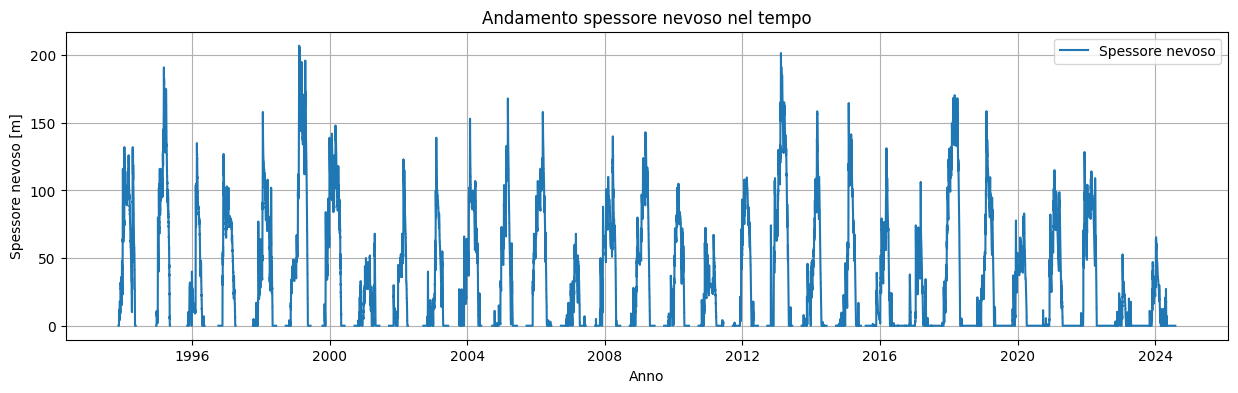

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))

sh.plot(x="time", ax = ax, label="Spessore nevoso")
ax.set_title("Andamento spessore nevoso nel tempo")
ax.set_ylabel("Spessore nevoso [m]")
ax.set_xlabel("Anno")

ax.legend(loc="best")
ax.grid(True)

plt.show()

Noto come inizialmente non sono state effettuate misure dello spessore nivale nel periodo estivo. Per evitare di introdurre qualche bias legato a delle errate misurazioni causate da un malfunzionamento strumentale provo a vedere se riesco a filtrare i dati in modo tale che vengano stampati a video solamente quelli con più di 2 cm di strato nevoso. In ogni caso si possono apprezzare delle annate caratterizzate da spessori nevosi particolamente scarsi, come per esempio durante il 2001, 2007, 2023, 2024. In questo sito non sono state osservate condizioni di snow drought nell'annata 2022, che è invece stata particolarmente problematica nelle alpi italiane.

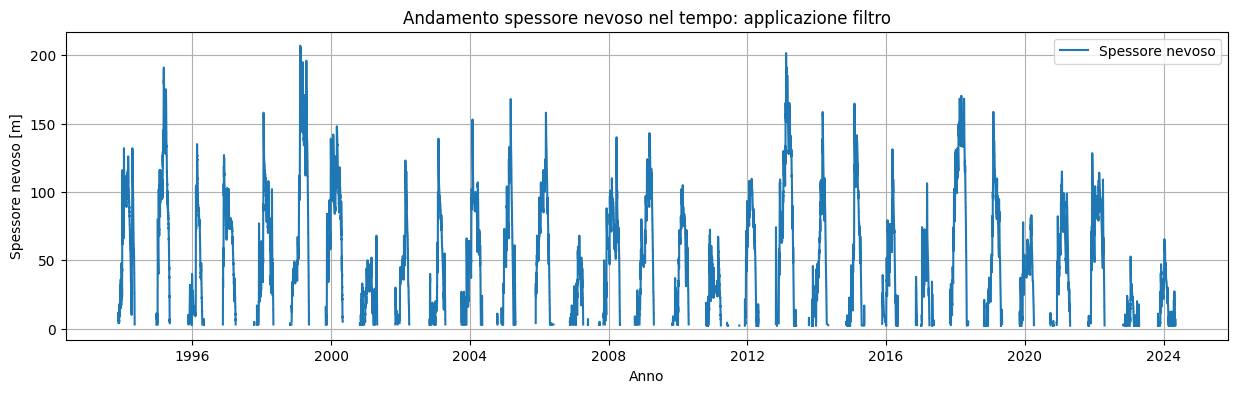

In [15]:
FILTER_VALUE = 2.0
appo = sh.where(sh > FILTER_VALUE)

fig, ax = plt.subplots(figsize=(15, 4))

appo.plot(x="time", ax = ax, label="Spessore nevoso")
ax.set_title("Andamento spessore nevoso nel tempo: applicazione filtro")
ax.set_ylabel("Spessore nevoso [m]")
ax.set_xlabel("Anno")

ax.legend(loc="best")
ax.grid(True)

plt.show()

<h1 style="color:blue; font-size:50px;"> Determinazione medie mensili</h1>

Procediamo ora con la determinazione delle medie mensili, di modo da poter valutare quale sia in media il mese caratterizzato dal maggior equivalente in acqua e per porre le basi per la ricerca di eventuali trend di crescita o diminuzione con il tempo della risorsa nivale.

In [ ]:
# In generale fare attenzione ad operazione di rounding (quando la faccio etc etc)
appo = np.zeros(shape = (6, 31))
anni = np.arange(1993, 2025, 1)
mesi = np.array(["01", "02", "03", "04", "11", "12"])

for j, year in enumerate(anni):
    for i, month in enumerate(mesi):

        # Check necessari per stampare correttamente titoli e riempire contenitore
        if year!=1993 and i<4:
            k = j-1
        elif year==1993 and i<4:
            continue
        elif year==2024 and i>=4:
            continue 
        else:
            k = j

        # Calcolo della SWE mensile (con check che valuta se risultato nan o meno)
        nome = str(year) + "-" + month
        sh_month = sh.sel(time=nome).mean()
        if np.isnan(sh_month):
            sh_month = 0.0
        else:
            sh_month = sh_month.item()
        
        # Collocazione della media nel contenitore adeguato
        sh_month = round(sh_month)
        appo[i, k] = sh_month

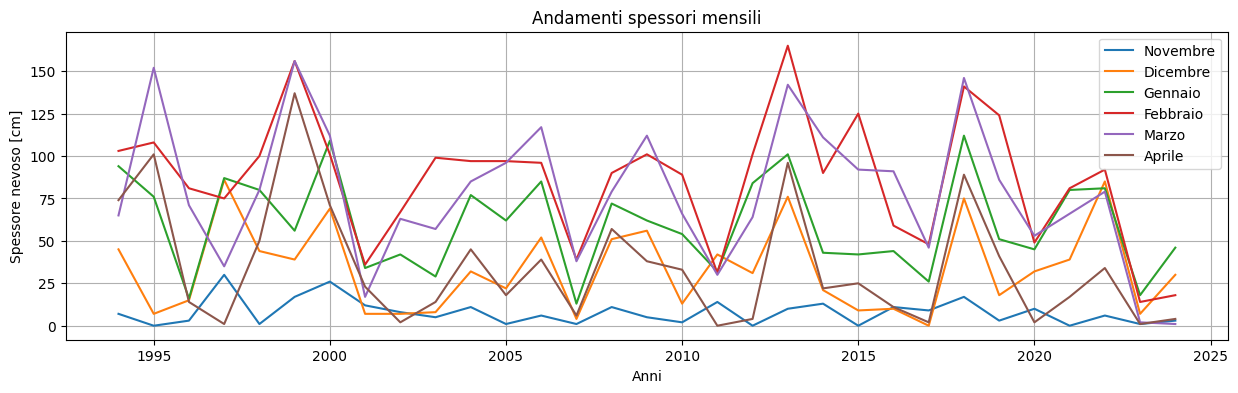

In [25]:
fig = plt.figure(figsize = (15, 4))
hydroY = np.arange(1994, 2025, 1)

plt.plot(hydroY, appo[4, :], label = "Novembre")
plt.plot(hydroY, appo[5, :], label = "Dicembre")
plt.plot(hydroY, appo[0, :], label = "Gennaio")
plt.plot(hydroY, appo[1, :], label = "Febbraio")
plt.plot(hydroY, appo[2, :], label = "Marzo")
plt.plot(hydroY, appo[3, :], label = "Aprile")

plt.title("Andamenti spessori mensili")
plt.ylabel("Spessore nevoso [cm]")
plt.xlabel("Anni")

plt.legend(loc="best")
plt.grid(True)
plt.show()

Valuto ora le medie per stagione d'accumulo dello spessore nevoso a terra. L'idea in questa fase del notebook è quella di riprodurre un grafico presente nel paper da cui ho ricavato questi dati, in modo tale da toccare con mano se la procedura di post-processing è corretta o meno. Dato che i mesi hanno durata differente, combino i valori precedentemente determinati utilizzando una media pesata sui giorni.

In [26]:
shY = np.zeros(31)

for i in range(0, 31):
    shY[i] = (31*appo[4, i] + 31*appo[0, i] + 28*appo[1, i] + 31*appo[2, i] + 30*appo[3, i])/(31+31+28+31+30)

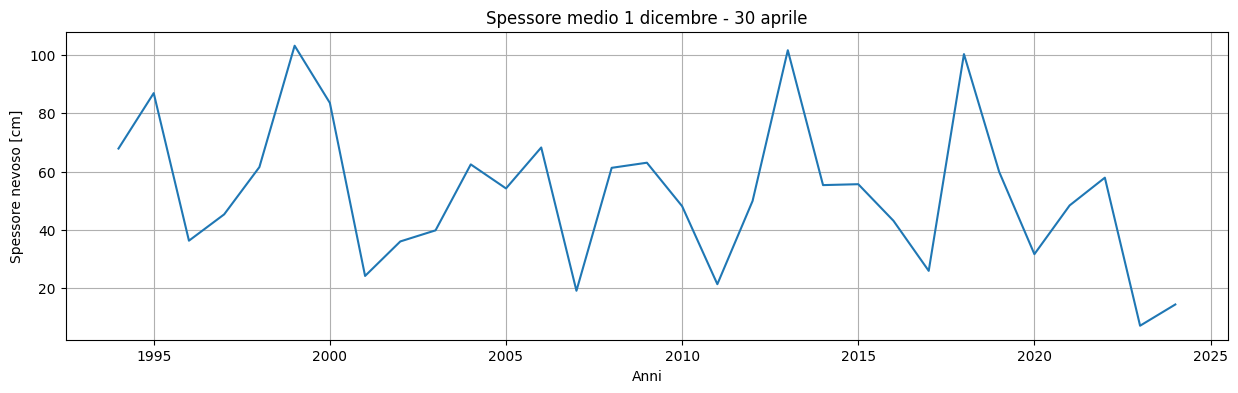

In [27]:
fig = plt.figure(figsize = (15, 4))
hydroY = np.arange(1994, 2025, 1)

plt.plot(hydroY, shY)


plt.title("Spessore medio 1 dicembre - 30 aprile")
plt.ylabel("Spessore nevoso [cm]")
plt.xlabel("Anni")

plt.grid(True)
plt.show()

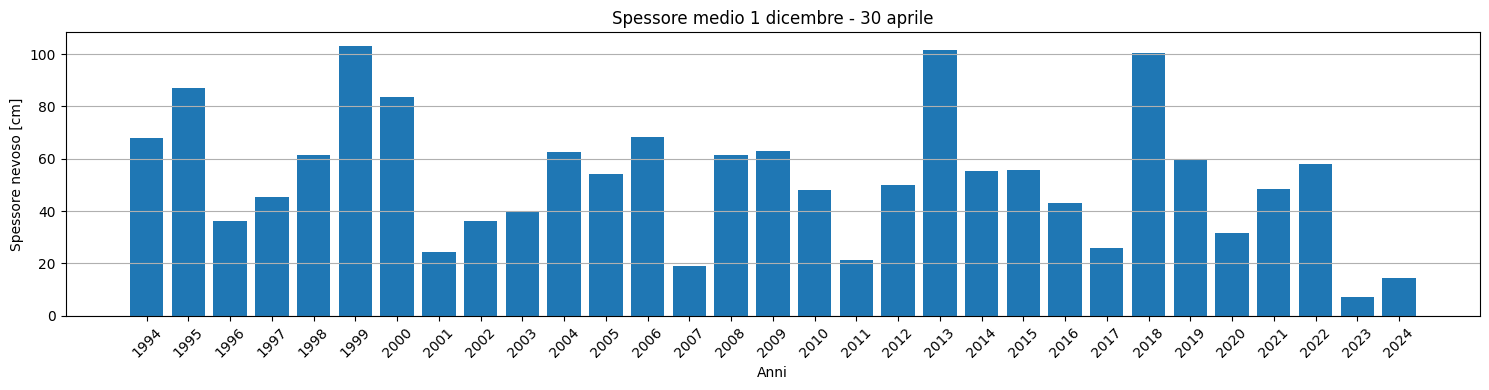

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))
hydroY = np.arange(1994, 2025, 1)

ax.bar(hydroY, shY, width=0.8)

ax.set_title("Spessore medio 1 dicembre - 30 aprile")
ax.set_ylabel("Spessore nevoso [cm]")
ax.set_xlabel("Anni")

ax.set_xticks(hydroY)               
ax.tick_params(axis="x", rotation=45)

ax.grid(True, axis="y") 
plt.tight_layout()
plt.show()

<h1 style="color:blue; font-size:50px;"> Temperatura dell'aria </h1>

Procedo l'analisi dei dati della AWS al Col de Porte prendendo in considerazione la temperatura dell'aria e la sua variabilità su scala mensile ed annuale. In particolare prendendo come banchmark il periodo 1994-2004 determino anche quelle che sono le anomalie.

In [29]:
# Apro il dataset utilizzando il comando open_dataset() e ne stampo a schermo la struttura
dat = xr.open_dataset("MetInSitu.nc")
dat

<xarray.Dataset> Size: 17MB
Dimensions:       (time: 271815, Number_of_points: 1)
Coordinates:
  * time          (time) datetime64[ns] 2MB 1993-08-01T06:00:00 ... 2024-08-0...
Dimensions without coordinates: Number_of_points
Data variables: (12/23)
    FRC_TIME_STP  float32 4B ...
    CO2air        (time, Number_of_points) float32 1MB ...
    DIR_SWdown    (time, Number_of_points) float32 1MB ...
    flag          (time, Number_of_points) float32 1MB ...
    HUMREL        (time, Number_of_points) float32 1MB ...
    LWdown        (time, Number_of_points) float32 1MB ...
    ...            ...
    UREF          (Number_of_points) float32 4B ...
    ZREF          (Number_of_points) float32 4B ...
    ZS            (Number_of_points) float32 4B ...
    aspect        (Number_of_points) float32 4B ...
    slope         (Number_of_points) float32 4B ...
    station       (Number_of_points) float64 8B ...

In [3]:
ta = dat["Tair"]

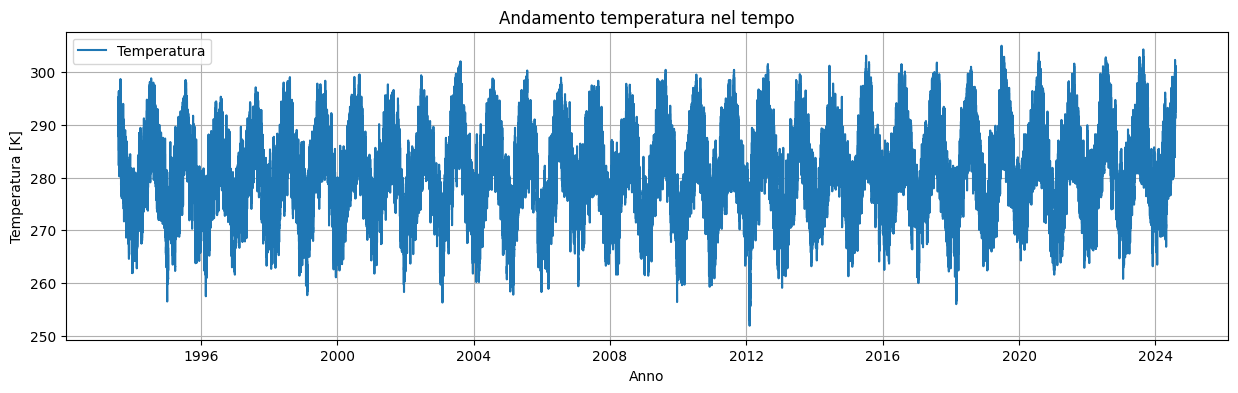

In [4]:
fig, ax = plt.subplots(figsize=(15, 4))

ta.plot(x="time", ax = ax, label="Temperatura")
ax.set_title("Andamento temperatura nel tempo")
ax.set_ylabel("Temperatura [K]")
ax.set_xlabel("Anno")

ax.legend(loc="best")
ax.grid(True)

plt.show()

### Scala mensile

In [37]:
appo = np.zeros(shape = (12, 31))
anni = np.arange(1993, 2025, 1)
mesi = np.array(["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"])

for j, year in enumerate(anni):
    for i, month in enumerate(mesi):

        # Check necessari per stampare correttamente titoli e riempire contenitore
        if year!=1993 and i<7:
            k = j-1
        elif year==1993 and i<7:
            continue
        elif year==2024 and i>=7:
            continue 
        else:
            k = j

        # Calcolo della SWE mensile (con check che valuta se risultato nan o meno)
        nome = str(year) + "-" + month
        t_month = ta.sel(time=nome).mean()
        if np.isnan(t_month):
            t_month = 0.0
        else:
            t_month = t_month.item()
        
        # Collocazione della media nel contenitore adeguato
        appo[i, k] = t_month

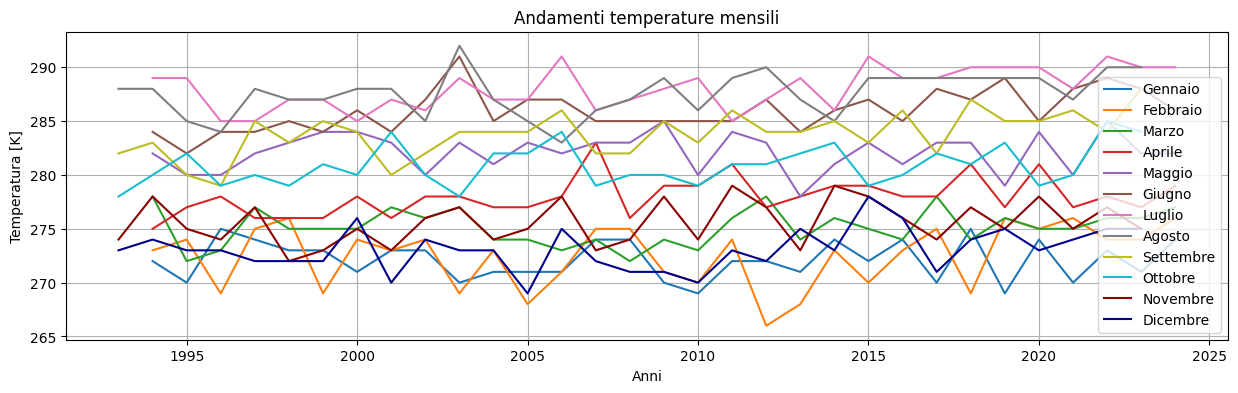

In [31]:
fig = plt.figure(figsize = (15, 4))
hydroY1 = np.arange(1994, 2025, 1)
hydroY2 = np.arange(1993, 2024, 1)

plt.plot(hydroY1, appo[0, :], label = "Gennaio")
plt.plot(hydroY1, appo[1, :], label = "Febbraio")
plt.plot(hydroY1, appo[2, :], label = "Marzo")
plt.plot(hydroY1, appo[3, :], label = "Aprile")
plt.plot(hydroY1, appo[4, :], label = "Maggio")
plt.plot(hydroY1, appo[5, :], label = "Giugno")
plt.plot(hydroY1, appo[6, :], label = "Luglio")
plt.plot(hydroY2, appo[7, :], label = "Agosto")
plt.plot(hydroY2, appo[8, :], label = "Settembre")
plt.plot(hydroY2, appo[9, :], label = "Ottobre")
plt.plot(hydroY2, appo[10, :], color = "darkred", label = "Novembre")
plt.plot(hydroY2, appo[11, :], color = "darkblue", label = "Dicembre")

plt.title("Andamenti temperature mensili")
plt.ylabel("Temperatura [K]")
plt.xlabel("Anni")

plt.legend(loc="best")
plt.grid(True)
plt.show()

### Scala annuale

In [43]:
# Attenzione: per fare le cose bene bene dovrei tenere conto degli anni bisestili
# Lavoro con anni idrologici, quindi da ottobre a settembre. Non ho dati per settembre 2024 => no anno idrologico 2024
taY = np.zeros(30)

for i in range(0, 30):
    taY[i] = (31*appo[0, i] + 28*appo[1, i] + 31*appo[2, i] + 30*appo[3, i]+ 31*appo[4, i] + 30*appo[5, i] + 31*appo[6, i] + 31*appo[7, i+1] + 30*appo[8, i+1] + 31*appo[9, i] + 30*appo[10, i] + 31*appo[11, i])/365

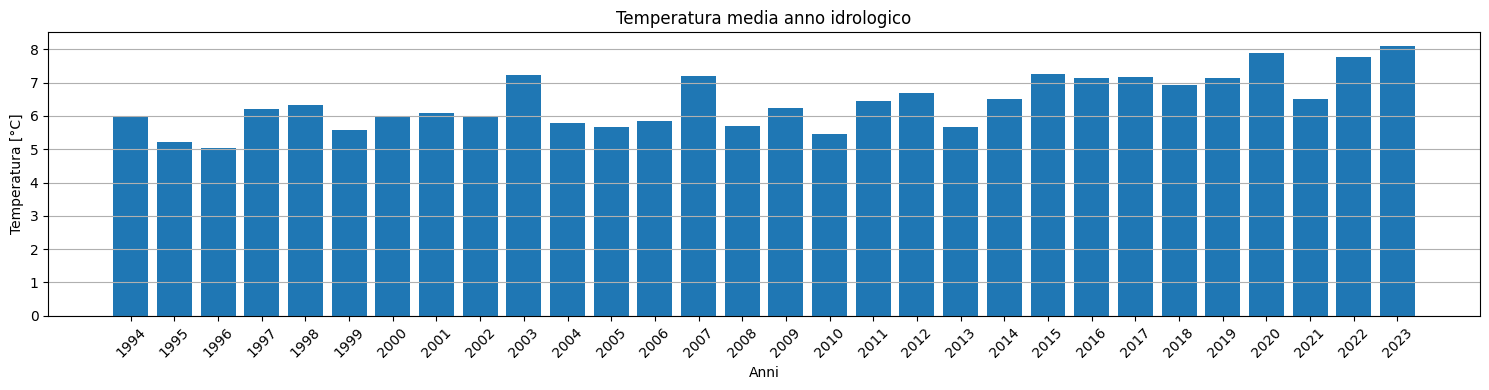

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
hydroY = np.arange(1994, 2024, 1)

ax.bar(hydroY, taY-273.15, width=0.8)

ax.set_title("Temperatura media anno idrologico")
ax.set_ylabel("Temperatura [°C]")
ax.set_xlabel("Anni")

ax.set_xticks(hydroY)               
ax.tick_params(axis="x", rotation=45)

ax.grid(True, axis="y") 
plt.tight_layout()
plt.show()

### Anomalie in temperatura

In [50]:
anTY = np.zeros(30)
meanT = np.mean(taY[0:10])
anTY = taY - meanT

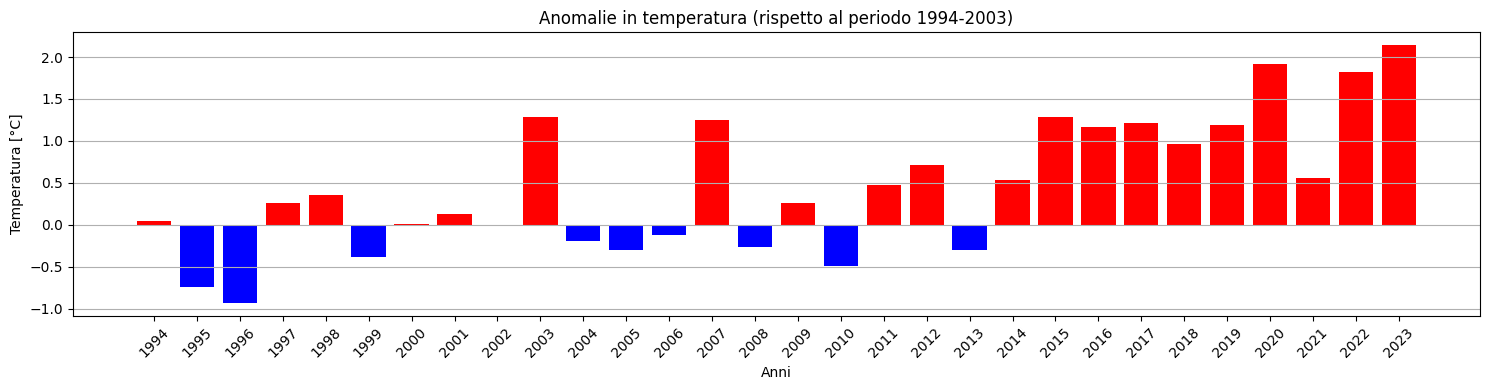

In [53]:
fig, ax = plt.subplots(figsize=(15, 4))
hydroY = np.arange(1994, 2024, 1)

colors = ["red" if val > 0 else "blue" for val in anTY]
ax.bar(hydroY, anTY, width=0.8, color=colors)

ax.set_title("Anomalie in temperatura (rispetto al periodo 1994-2003)")
ax.set_ylabel("Temperatura [°C]")
ax.set_xlabel("Anni")

ax.set_xticks(hydroY)               
ax.tick_params(axis="x", rotation=45)

ax.grid(True, axis="y") 
plt.tight_layout()
plt.show()

Voglio ora identificare quali siano le stagioni caratterizzate dalle maggiori anomalie. Divido per quesot motivo le annate in: 
- Autunno: Settembre --> Novembre
- Inverno: Dicembre --> Febbraio
- Primavera: Marzo --> Maggio
- Estate: Giugno --> Agosto

In [93]:
auT = np.zeros(31)
inT = np.zeros(31)
prT = np.zeros(31)
esT = np.zeros(31)

for i in range(0, 31):
    auT[i] = (30*appo[8, i] + 31*appo[9, i] + 30*appo[10, i])/91
    inT[i] = (31*appo[11, i] + 31*appo[0, i] + 28*appo[1, i])/90
    prT[i] = (31*appo[2, i] + 30*appo[3, i] + 31*appo[4, i])/92
    if i < 30:
        esT[i] = (30*appo[5, i] + 31*appo[6, i] + 31*appo[7, i+1])/92
    else:
        esT[i] = (30*appo[5, i] + 31*appo[6, i] + 31*ta.sel(time="2024-08").mean().item())/92

meanA = np.mean(auT[0:10]); auA = auT - meanA
meanI = np.mean(inT[0:10]); inA = inT - meanI
meanP = np.mean(prT[0:10]); prA = prT - meanP
meanE = np.mean(esT[0:10]); esA = esT - meanE

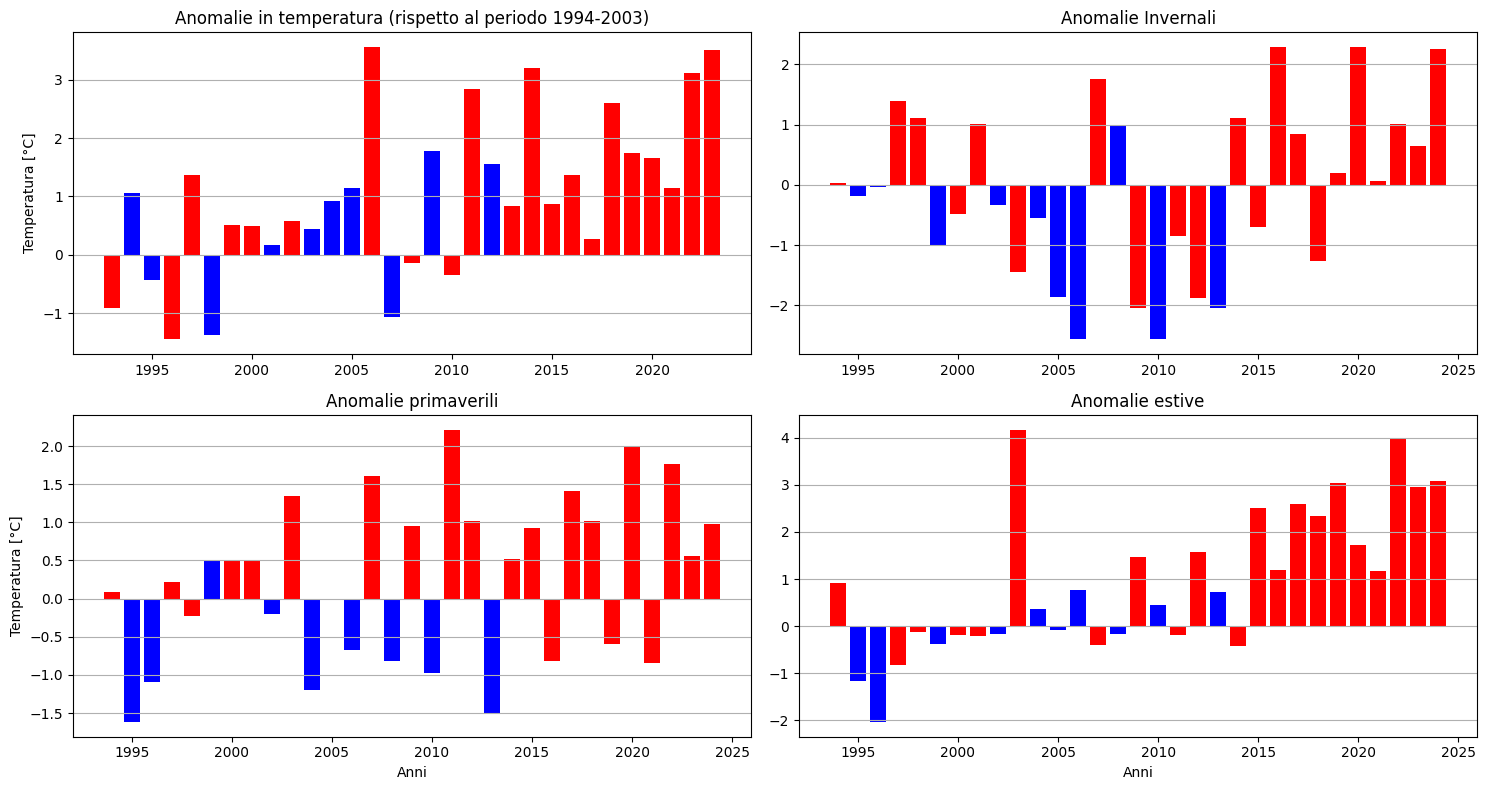

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
colors = ["red" if val > 0 else "blue" for val in anTY]

hydroY1 = np.arange(1993, 2024, 1)
hydroY2 = np.arange(1994, 2025, 1)

# Anomalie autunnali
axs[0, 0].bar(hydroY1, auA, width=0.8, color=colors)
axs[0, 0].set_title("Anomalie in temperatura (rispetto al periodo 1994-2003)")
axs[0, 0].set_ylabel("Temperatura [°C]")
axs[0, 0].grid(True, axis="y") 

# Anomalie invernali
axs[0, 1].bar(hydroY2, inA, width=0.8, color=colors)
axs[0, 1].set_title("Anomalie Invernali")
axs[0, 1].grid(True, axis="y") 


# Anomalie primaverili
axs[1, 0].bar(hydroY2, prA, width=0.8, color=colors)
axs[1, 0].set_title("Anomalie primaverili")
axs[1, 0].set_ylabel("Temperatura [°C]")
axs[1, 0].set_xlabel("Anni")
axs[1, 0].grid(True, axis="y") 


# Anomalie estive
axs[1, 1].bar(hydroY2, esA, width=0.8, color=colors)
axs[1, 1].set_title("Anomalie estive")
axs[1, 1].set_xlabel("Anni")
axs[1, 1].grid(True, axis="y") 


plt.tight_layout()
plt.show()